In [19]:
import skimage
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import time
import argparse
import cv2
from scipy import io
from tqdm.notebook import tqdm

import torch
from torch import nn
import torch.nn.functional as F
import torchvision.models as models
import torch.optim.lr_scheduler as lr_scheduler

from modules import utils
from modules.models import INR

In [20]:
parser = argparse.ArgumentParser(description='STAF image representation')

# Shared Parameters
parser.add_argument('--input',type=str, default='./data/Image/celtic_spiral_knot.jpg', help='Input image path')
parser.add_argument('--inr_model',type=str, default='staf', help='[gauss, mfn, relu, siren, wire, wire2d, ffn, incode, finer, staf]')
parser.add_argument('--lr',type=float, default=1e-3, help='Learning rate')
parser.add_argument('--using_schedular', type=bool, default=True, help='Whether to use schedular')
parser.add_argument('--scheduler_b', type=float, default=0.05, help='Learning rate scheduler')
parser.add_argument('--maxpoints', type=int, default=64*64, help='Batch size')
parser.add_argument('--niters', type=int, default=1001, help='Number if iterations')
parser.add_argument('--tau', type=int, default=10, help='Tau value (Number of frequencies) for STAF.')
parser.add_argument('--steps_til_summary', type=int, default=100, help='Number of steps till summary visualization')

# INCODE Parameters
parser.add_argument('--a_coef',type=float, default=0.1993, help='a coeficient')
parser.add_argument('--b_coef',type=float, default=0.0196, help='b coeficient')
parser.add_argument('--c_coef',type=float, default=0.0588, help='c coeficient')
parser.add_argument('--d_coef',type=float, default=0.0269, help='d coeficient')


args = parser.parse_args(args=[])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Loading Data

In [21]:
im = utils.normalize(plt.imread(args.input).astype(np.float32), True)
im = cv2.resize(im, None, fx=1/5, fy=1/5, interpolation=cv2.INTER_AREA)
H, W, _ = im.shape

print(f'H, W: {H}, {W}')

H, W: 114, 116


## Defining Model

### Defining desired Positional Encoding

In [22]:
# Frequency Encoding
pos_encode_freq = {'type':'frequency', 'use_nyquist': True, 'mapping_input': int(max(H, W)/3)}

# Gaussian Encoding
pos_encode_gaus = {'type':'gaussian', 'scale_B': 10, 'mapping_input': 256}

# No Encoding
pos_encode_no = {'type': None}

### Model Configureations

In [17]:
if args.inr_model == 'incode':
    ### INCODE Harmonizer Configurations
    MLP_configs={'task': 'image',
              'model': 'resnet34',
              'truncated_layer':5,
              'in_channels': 64,
              'hidden_channels': [64, 32, 4],
              'mlp_bias':0.3120,
              'activation_layer': nn.SiLU,
              'GT': torch.tensor(im).to(device)[None,...].permute(0, 3, 1, 2)
              }
    
    ### Model Configurations
    model = INR(args.inr_model).run(in_features=2,
                                  out_features=3,
                                  hidden_features=256,
                                  hidden_layers=3,
                                  first_omega_0=30.0,
                                  hidden_omega_0=30.0,
                                  pos_encode_configs=pos_encode_no,
                                  MLP_configs = MLP_configs
                                ).to(device)
    
elif args.inr_model == 'finer':
    model = INR(args.inr_model).run(in_features=2,
                                out_features=3, 
                                hidden_features=256,
                                hidden_layers=3,
                                first_omega_0=30.0,
                                hidden_omega_0=30.0,
                                first_bias_scale=5.0,
                               ).to(device)

elif args.inr_model == 'wire':
    model = INR(args.inr_model).run(
        in_features=2,
        hidden_features=300,
        hidden_layers=3,
        out_features=3,
        first_omega_0=30,
        hidden_omega_0=30,
        sigma=10.0,
        wire_type='complex',
        pos_encode_configs=pos_encode_no
    ).to(device)

elif args.inr_model == 'mfn':
    model = INR(args.inr_model).run(
        in_features=2,
        out_features=3,
        hidden_features=256,
        hidden_layers=3,
        pos_encode_configs=pos_encode_no
    ).to(device)

elif args.inr_model == 'gauss':
    model = INR(args.inr_model).run(
        in_features=2,
        out_features=3,
        hidden_features=256,
        hidden_layers=3,
        sigma=10,
        pos_encode_configs=pos_encode_no
    ).to(device)

elif args.inr_model == 'relu':
    model = INR(args.inr_model).run(in_features=2,
                               out_features=3,
                               hidden_features=256,
                               hidden_layers=3,
                               pos_encode_configs=pos_encode_relu
                        ).to(device)

elif args.inr_model == 'staf':
      model = INR(args.inr_model).run(in_features=2,
                                      out_features=3,
                                      hidden_features=256,
                                      hidden_layers=3,
                                      first_omega_0=30.0*2,
                                      hidden_omega_0=30.0,
                                      tau=args.tau
                                    ).to(device)

else:
    ### Model Configurations
      model = INR(args.inr_model).run(in_features=2,
                                      out_features=3,
                                      hidden_features=256,
                                      hidden_layers=3,
                                      first_omega_0=30.0,
                                      hidden_omega_0=30.0
                                    ).to(device)

## Training Code

In [13]:
# Optimizer setup
if args.inr_model == 'wire':
    args.lr = args.lr * min(1, args.maxpoints / (H * W))
optim = torch.optim.Adam(lr=args.lr, params=model.parameters())
scheduler = lr_scheduler.LambdaLR(optim, lambda x: args.scheduler_b ** min(x / args.niters, 1))

# Initialize lists for PSNR and MSE values
psnr_values = []
mse_array = torch.zeros(args.niters, device=device)

# Initialize best loss value as positive infinity
best_loss = torch.tensor(float('inf'))

# Generate coordinate grid
coords = utils.get_coords(H, W, dim=2)[None, ...]

# Convert input image to a tensor and reshape
gt = torch.tensor(im).reshape(H * W, 3)[None, ...].to(device)

# Initialize a tensor for reconstructed data
rec = torch.zeros_like(gt)

  0%|          | 0/1001 [00:00<?, ?it/s]

Epoch: 0 | Total Loss: 0.25813 | PSNR: 5.8817


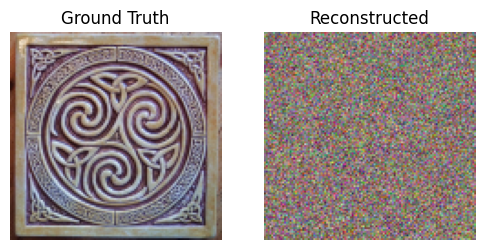

Epoch: 100 | Total Loss: 0.00016 | PSNR: 37.9715


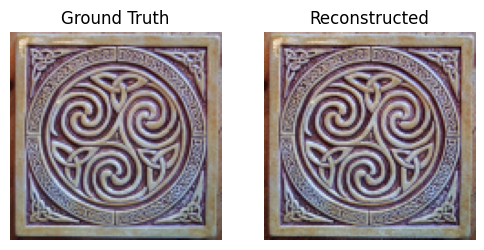

Epoch: 200 | Total Loss: 0.00009 | PSNR: 40.4325


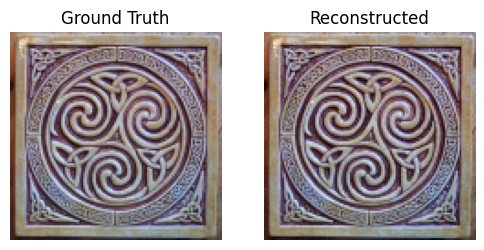

Epoch: 300 | Total Loss: 0.00002 | PSNR: 46.5149


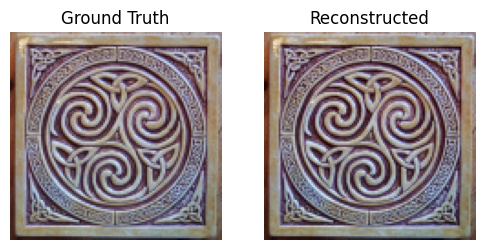

Epoch: 400 | Total Loss: 0.00000 | PSNR: 55.6870


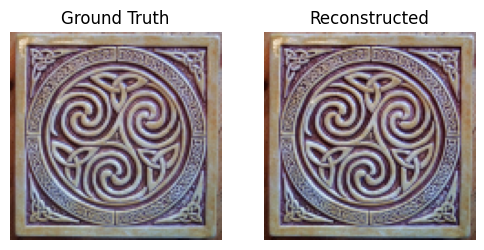

Epoch: 500 | Total Loss: 0.00000 | PSNR: 74.6762


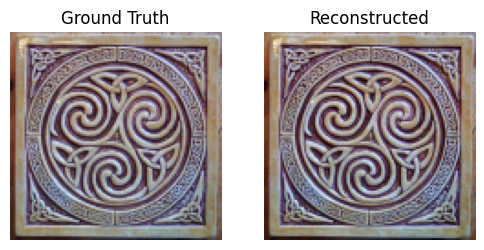

Epoch: 600 | Total Loss: 0.00000 | PSNR: 104.5191


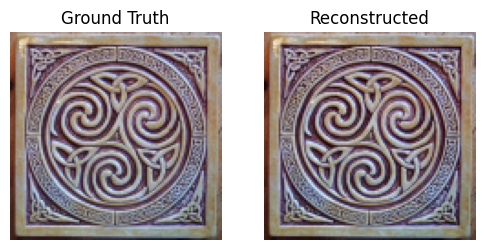

Epoch: 700 | Total Loss: 0.00000 | PSNR: 119.4882


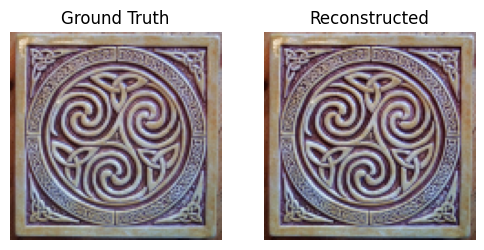

Epoch: 800 | Total Loss: 0.00000 | PSNR: 121.3381


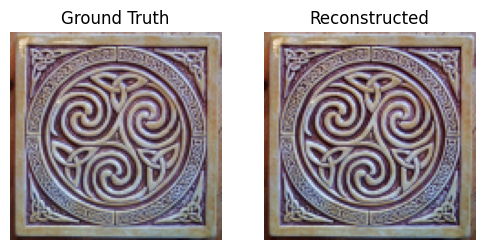

Epoch: 900 | Total Loss: 0.00000 | PSNR: 122.1349


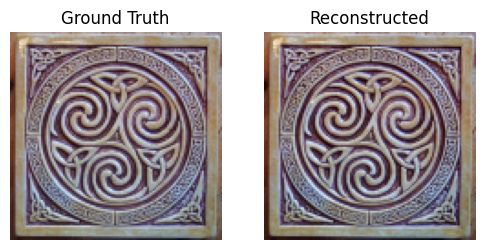

Epoch: 1000 | Total Loss: 0.00000 | PSNR: 122.7141


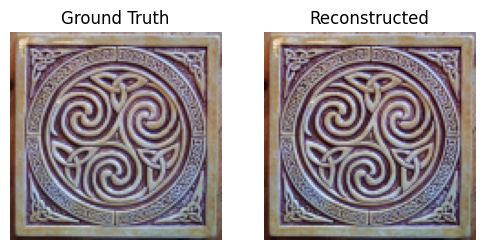

--------------------
Max PSNR: 122.74555206298828
--------------------


In [14]:
for step in tqdm(range(args.niters)):
    # Randomize the order of data points for each iteration
    indices = torch.randperm(H*W)

    # Process data points in batches
    for b_idx in range(0, H*W, args.maxpoints):
        b_indices = indices[b_idx:min(H*W, b_idx+args.maxpoints)]
        b_coords = coords[:, b_indices, ...].to(device)
        b_indices = b_indices.to(device)

        # Calculate model output
        if args.inr_model == 'incode':
            model_output, coef = model(b_coords)
        else:
            model_output = model(b_coords)

        # Update the reconstructed data
        with torch.no_grad():
            rec[:, b_indices, :] = model_output

        # Calculate the output loss
        output_loss = ((model_output - gt[:, b_indices, :])**2).mean()

        if args.inr_model == 'incode':
            # Calculate regularization loss for 'incode' model
            a_coef, b_coef, c_coef, d_coef = coef[0]
            reg_loss = args.a_coef * torch.relu(-a_coef) + \
                       args.b_coef * torch.relu(-b_coef) + \
                       args.c_coef * torch.relu(-c_coef) + \
                       args.d_coef * torch.relu(-d_coef)

            # Total loss for 'incode' model
            loss = output_loss + reg_loss
        else:
            # Total loss for other models
            loss = output_loss

        # Perform backpropagation and update model parameters
        optim.zero_grad()
        loss.backward()
        optim.step()

    # Calculate PSNR
    with torch.no_grad():
        mse_array[step] = ((gt - rec)**2).mean().item()
        psnr = -10*torch.log10(mse_array[step])
        psnr_values.append(psnr.item())

    # Adjust learning rate using a scheduler if applicable
    if args.using_schedular:
        if args.inr_model == 'incode' and 30 < step:
            scheduler.step()
        else:
            scheduler.step()

    # Prepare reconstructed image for visualization
    imrec = rec[0, ...].reshape(H, W, 3).detach().cpu().numpy()

    # Check if the current iteration's loss is the best so far
    if (mse_array[step] < best_loss) or (step == 0):
        best_loss = mse_array[step]
        best_img = imrec
        best_img = (best_img - best_img.min()) / (best_img.max() - best_img.min())

    # Display intermediate results at specified intervals
    if step % args.steps_til_summary == 0:
        print("Epoch: {} | Total Loss: {:.5f} | PSNR: {:.4f}".format(step,
                                                                     mse_array[step].item(),
                                                                     psnr.item()))

        # Plot
        fig, axes = plt.subplots(1, 2, figsize=(6, 6))
        axes[0].set_title('Ground Truth')
        axes[0].imshow(im)
        axes[0].axis('off')
        axes[1].set_title('Reconstructed')
        axes[1].imshow(best_img)
        axes[1].axis('off')
        plt.show()


# Print maximum PSNR achieved during training
print('--------------------')
print('Max PSNR:', max(psnr_values))
print('--------------------')

# Convergance Rate

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

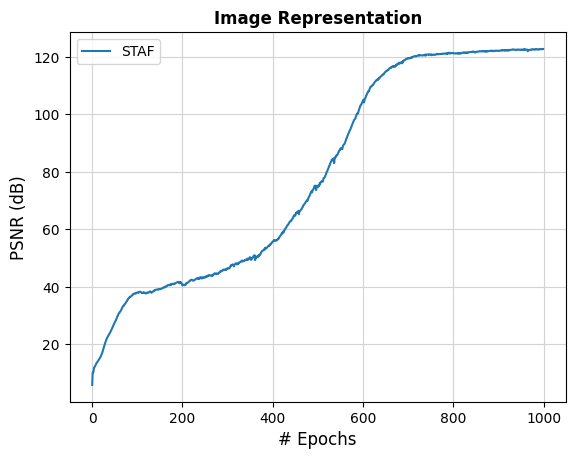

In [15]:
font = {'font': 'Times New Roman', 'size': 12}

plt.figure()
axfont = {'family' : 'Times New Roman', 'weight' : 'regular', 'size'   : 10}
plt.rc('font', **axfont)

plt.plot(np.arange(len(psnr_values[:-1])), psnr_values[:-1], label = f"{(args.inr_model).upper()}")
plt.xlabel('# Epochs', fontdict=font)
plt.ylabel('PSNR (dB)', fontdict=font)
plt.title('Image Representation', fontdict={'family': 'Times New Roman', 'size': 12, 'weight': 'bold'})
plt.legend()
plt.grid(True, color='lightgray')

plt.show()